# Development of Emotion and Reasoning in the General Speeches of the United Nations: A text-based machine learning approach
## Script 0: Data Cleaning, Preprocessing & Token Frequencies
### Author: Sarah Franzen

### Instructions BEFORE running this script:
- Ensure all required packages are installed. If not, set `InstallPackages = TRUE` (see code cells below).  
- Set your working directory appropriately.  
- The script will automatically create the required folder structure.  
- Later, you will be asked to download the folder "UNGDC_1946_2024.tar.gz" from:  
  https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/0TJX8Y  
  and store it **unzipped** inside the created folder *data_original*


### Description: 
- Extract documents from their original txt documents and store them as one csv
- Create new variables
    - year, country_code, country_name
    - speech_length_words
    - english_official_language
    - security_council_permanent
    - gender
    - position
    - speaker_name
    - Country (Year)
- Cleaning
    - remove line breaks, hypehnation etc.
- Preprocessing
    - remove punctuation, tokenize, lowercase, pure digit tokens, words shorter than 2 letters, POS-Tagging, stemm, stopword removal
    - create new variable: speech_length_preprocessd
- Word Frequencies
    - word counts of the preprocessed_corpus
    - count frequency of the dictionary words
    - calculate weighted frequency
- Final preprocessing (Not correct, I think)
    - Remove words that appear less than 10x times from the preprocessed corpus 

___

## Setup, Installation of required Packages and Libraries & Folder Structure

In [1]:
InstallPackages = False # Set this to True to install the following packages 

if InstallPackages:
    import sys

    packages = [
        "pandas",
        "nltk",
        "spacy",
        "numpy",
        "gensim",
        "pycountry",
        "matplotlib",
        "tqdm",
        "seaborn",
        "joblib",
        "scipy",
        "tabulate",
        "rapidfuzz"
    ]

    for package in packages:
        if importlib.util.find_spec(package) is None:
            !{sys.executable} -m pip install {package}


DownloadAdditions = False # Set this to True to download these additional resources
if DownloadAdditions:
    nltk.download("punkt")
    nltk.download("averaged_perceptron_tagger")
    spacy.cli.download('en_core_web_lg') 

In [2]:
# == Import libraries for data processing and NLP ==

import gensim
import joblib
import nltk
import os
import pandas as pd
import pycountry
import random
import re
import spacy
import time
import pickle
import numpy as np

from collections import Counter
from itertools import chain
from multiprocessing import Pool, freeze_support
from nltk.stem import SnowballStemmer
from spacy.lang.en.stop_words import STOP_WORDS as SPACY_STOPWORDS
from string import punctuation
from tqdm import tqdm
from pathlib import Path
from rapidfuzz import process, fuzz

# === Initialize NLP Tools ===

translator = str.maketrans('', '', punctuation)
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
stemmer = SnowballStemmer("english")
tagger = nltk.perceptron.PerceptronTagger()

In [3]:
# === Set Working Directory and create folder structure ===

# Prompt user to enter working directory path
#wd = input("Please enter your working directory path (e.g., C:\\Users\\sarah\\OneDrive\\Dokumente\\Masterarbeit): ").strip()

# Change to the entered working directory
#try:
   # os.chdir(wd)
    #print(f"Working directory set to: {os.getcwd()}")
#except FileNotFoundError:
   # print("ERROR: The directory you entered does not exist. Please restart and enter a valid path.")
    #exit(1)

# Set your working directory (adjust this as needed)

wd = Path(r"C:\Users\sarah\OneDrive\Dokumente\Masterarbeit")
os.chdir(wd)

# Set base path to current working directory
base_path = Path.cwd()
data_path = base_path / "data"

# List of subfolders to create inside 'data'
subfolders = ["data_original", "dictionaries", "freq", "preprocessed", "temp"]

# Create 'data' folder if it doesn't exist
data_path.mkdir(exist_ok=True)

# Create subfolders
for name in subfolders:
    (data_path / name).mkdir(exist_ok=True)

print("\nFolder structure created:")
print(f"- {data_path}")
for name in subfolders:
    print(f"  - {name}")

# Prompt user to place raw data files
#print(f"\nPlease place your raw data files (unzipped) into the folder:\n  {data_path / 'data_original'}")
#input("Press Enter after you have placed the files to continue...")

#print("Continuing with the script...")



Folder structure created:
- C:\Users\sarah\OneDrive\Dokumente\Masterarbeit\data
  - data_original
  - dictionaries
  - freq
  - preprocessed
  - temp


In [4]:
# === Define Folder Paths ===

# If an error occurs, make sure that you actually have these folders in your working directory

data_c = wd / "data"
data_temp = data_c / "temp"
data_freq = data_c / "freq"
data_dict = data_c / "dictionaries"
data_preprocessed = data_c / "preprocessed"
fig_dir = wd /"fig"

In [5]:
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\sarah\OneDrive\Dokumente\Masterarbeit


___

## Load and Prepare Corpus

In [625]:
# == Load the txt-files from the UN General Debate Corpus ==

# Set Folder path containing the original TXT files    
base_folder = r".\data\data_original\TXT"

# Collect txt-files
all_txt_files = []
for root, dirs, files in os.walk(base_folder):
    for file in files:
        if file.endswith('.txt') and not file.startswith('._'):
            all_txt_files.append(os.path.join(root, file))

print(f"Total speeches found: {len(all_txt_files)}")

# Randomly pick 800 files from the full collection   ################################################# REMOVE AT LATER POINT
sampled_files = random.sample(all_txt_files,10953)

# Read the selected files into a list
raw_data = []
for filepath in sampled_files:
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()
        raw_data.append({'filename': os.path.basename(filepath), 'speech': content})

df_raw = pd.DataFrame(raw_data)

# Include only valid filenames
df_raw = df_raw[df_raw['filename'] != '.DS_Store-to-UTF-8.txt'].copy()

# Drop empty speeches
df_raw['speech'] = df_raw['speech'].astype(str)
df_raw = df_raw[df_raw['speech'].str.strip() != ''].copy()

# Check for duplicates
dupe_labels = df_raw[df_raw.duplicated(subset=['filename', 'speech'], keep=False)]
print(dupe_labels[['filename', 'speech']].head(20))

# == Store as csv and pkl ==

raw_pickle_path = r".\data\un_corpus_raw.pkl"
df_raw.to_pickle(raw_pickle_path)

raw_output_path = r".\data\un_corpus_raw.csv"
df_raw.to_csv(raw_output_path, index=False, sep=';', encoding='utf-8')

print(f"\n Saved raw data with {len(df_raw)} speeches to '{raw_output_path}'")


Total speeches found: 10953
Empty DataFrame
Columns: [filename, speech]
Index: []

 Saved raw data with 10952 speeches to '.\data\un_corpus_raw.csv'


## Is this necessary?

In [7]:
# == Load data ==

df_raw = pd.read_pickle(r".\data\un_corpus_raw.pkl")
df_raw.head()         

,filename,speech
0,AUT_11_1956.txt,Permit me first of all to express to Prince Wa...
1,IDN_65_2010.txt,"First I congratulate \nyou, Sir, on your assu..."
2,MNE_73_2018.txt,It is my pleasure to address the General Assem...
3,BEN_19_1964.txt,"74.\tIt is a particular pleasure for me, Mr. P..."
4,TTO_57_2002.txt,﻿Please allow\nme to preface my indication by ...


___

## Create new variables

#### New Variables: Year, Country Code and Country Name

In [11]:
# == Create variable: country code & year ==

# Create contry_code and year variable
df_raw['country_code'] = df_raw['filename'].str.extract(r'^([A-Z]{2,3})')
df_raw['year'] = df_raw['filename'].str.extract(r'_(\d{4})\.txt$').astype(int)

print("Min year:", df_raw['year'].min())
print("Max year:", df_raw['year'].max())
# Speeches range from 1946 to 2023

# == Create variable: country_name by matching ISO country code 
code_to_name = {country.alpha_3: country.name for country in pycountry.countries}

# Add custom short names and legacy codes
custom_names = {
    "BOL": "Bolivia",
    "COD": "Democratic Republic of Congo",
    "IRN": "Iran",
    "LAO": "Laos",
    "MDA": "Moldova",
    "PRK": "North Korea",
    "PSE": "Palestine",
    "RUS": "Russia",
    "SYR": "Syria",
    "TZA": "Tanzania",
    "VAT": "Vatican City State",
    "VEN": "Venezuela",
    "VNM": "Vietnam",
    "YMD": "South Yemen",
    "YUG": "Yugoslavia",
    "DDR": "East Germany",
    "EU": "European Union",
    "CSK": "Czechoslovakia",
    "FSM": "Micronesia",
    "KOR": "South Korea"
}

code_to_name.update(custom_names)
df_raw['country_name'] = df_raw['country_code'].map(code_to_name)

# Check missing mappings
missing = df_raw.loc[df_raw['country_name'].isna(), 'country_code'].unique()
print("Missing codes:", missing)

Min year: 1946
Max year: 2024
Missing codes: []


In [12]:
# == Check country names and structure ==

pd.set_option('display.max_rows', None)
print(df_raw[['country_code', 'country_name']].drop_duplicates().sort_values('country_code').reset_index(drop=True))
pd.reset_option('display.max_rows')

    country_code                      country_name
0            AFG                       Afghanistan
1            AGO                            Angola
2            ALB                           Albania
3            AND                           Andorra
4            ARE              United Arab Emirates
5            ARG                         Argentina
6            ARM                           Armenia
7            ATG               Antigua and Barbuda
8            AUS                         Australia
9            AUT                           Austria
10           AZE                        Azerbaijan
11           BDI                           Burundi
12           BEL                           Belgium
13           BEN                             Benin
14           BFA                      Burkina Faso
15           BGD                        Bangladesh
16           BGR                          Bulgaria
17           BHR                           Bahrain
18           BHS               

#### New Variable: Length of speeches

In [14]:
# Count total number of unique tokens in the corpus
all_tokens = set()
for speech in df_raw['speech']:
    all_tokens.update(str(speech).split())
print("Total number of unique tokens in the corpus:", len(all_tokens))

# Count total number of tokens in the corpus
total_tokens = df_raw['speech'].apply(lambda x: len(str(x).split())).sum()
print("Total number of tokens in the corpus:", total_tokens)

# Add a new column: speech length in words
df_raw['speech_length_words'] = df_raw['speech'].apply(lambda x: len(str(x).split()))

# Calculate average length
avg_length = df_raw['speech_length_words'].mean()
print("Average speech length (words):", round(avg_length, 2))

# 20 shortest & longest speeches
print("20 shortest speeches:")
print(df_raw.nsmallest(20, 'speech_length_words')[['filename', 'country_name', 'year', 'speech_length_words']])

print("\n20 longest speeches:")
print(df_raw.nlargest(20, 'speech_length_words')[['filename', 'country_name', 'year', 'speech_length_words']])

Total number of unique tokens in the corpus: 225938
Total number of tokens in the corpus: 31911386
Average speech length (words): 2913.75
20 shortest speeches:
              filename                      country_name  year  \
9542   EGY_28_1973.txt                             Egypt  1973   
7224   VCT_41_1986.txt  Saint Vincent and the Grenadines  1986   
4151   BEN_71_2016.txt                             Benin  2016   
4695   GNB_76_2021.txt                     Guinea-Bissau  2021   
6117   HTI_01_1946.txt                             Haiti  1946   
3916   RWA_76_2021.txt                            Rwanda  2021   
8853   DDR_45_1990.txt                      East Germany  1990   
9400   LTU_73_2018.txt                         Lithuania  2018   
4285   RWA_69_2014.txt                            Rwanda  2014   
10265  IRN_01_1946.txt                              Iran  1946   
5425   LTU_72_2017.txt                         Lithuania  2017   
5338   RWA_70_2015.txt                          

#### New variable: English as Official Language

In [16]:
# Source for english as official language : https://gradschool.utk.edu/future-students/office-of-graduate-admissions/applying-to-graduate-school/admission-requirements/testing-requirements/countries-with-english-as-official-language/
# They are quoting: https://www.cia.gov/the-world-factbook/field/languages/

english_countries = [
    "Anguilla", "Antigua and Barbuda", "Bahamas", "Barbados", "Belize", "Belgium",
    "Bermuda", "Botswana", "British Virgin Islands", "Burundi", "Cameroon", "Canada",
    "Cayman Islands", "Christmas Island", "Cook Islands", "Dominica", "Fiji", "Gambia",
    "Ghana", "Grenada", "Guyana", "Hong Kong", "India", "Ireland", "Jersey", "Kenya",
    "Liberia", "Malawi", "Malta", "Marshall Islands", "Micronesia",
    "Namibia", "New Zealand", "Nigeria", "Niue", "Norfolk Island", "Northern Mariana Islands",
    "Pakistan", "Palau", "Papua New Guinea", "Philippines", "Pitcairn Islands", "Rwanda",
    "Saint Kitts and Nevis", "Saint Lucia", "Samoa", "Seychelles", "Sierra Leone", "Singapore",
    "Sint Maarten", "Solomon Islands", "Somalia", "South Africa", "South Sudan", "Sudan",
    "Eswatini", "Tanzania", "Tonga", "Trinidad and Tobago", "Turks and Caicos Islands",
    "Tuvalu", "Uganda", "Zambia", "Zimbabwe"
]

# Create dummy column for english being the official language
df_raw['english_official_language'] = df_raw['country_name'].apply(
    lambda x: 1 if x in english_countries else 0
)

# Detect unmatched countries 
matched = set(df_raw['country_name'])
unmatched = [country for country in english_countries if country not in matched]

print("Countries not matched in df_raw['country_name']:")
for country in unmatched:
    print(country)

# All of these countries are either British Overseas Territories, Australian Territories, self-governing island territories or Special Administrative Regions
    # None of the unmatched regions are UN Members

# Check df with new variable english_official_language
df_raw.head()


Countries not matched in df_raw['country_name']:
Anguilla
Bermuda
British Virgin Islands
Cayman Islands
Christmas Island
Cook Islands
Hong Kong
Jersey
Niue
Norfolk Island
Northern Mariana Islands
Pitcairn Islands
Sint Maarten
Turks and Caicos Islands


,filename,speech,country_code,year,country_name,speech_length_words,english_official_language
0,AUT_11_1956.txt,Permit me first of all to express to Prince Wa...,AUT,1956,Austria,1850,0
1,IDN_65_2010.txt,"First I congratulate \nyou, Sir, on your assu...",IDN,2010,Indonesia,1361,0
2,MNE_73_2018.txt,It is my pleasure to address the General Assem...,MNE,2018,Montenegro,2089,0
3,BEN_19_1964.txt,"74.\tIt is a particular pleasure for me, Mr. P...",BEN,1964,Benin,3686,0
4,TTO_57_2002.txt,﻿Please allow\nme to preface my indication by ...,TTO,2002,Trinidad and Tobago,2484,1


#### New variable: Permanent member security council

In [18]:
# Define permanent members of the UN Security Council and create dummy
permanent_members = ['RUS', 'USA', 'FRA', 'GBR', 'CHN']

df_raw['security_council_permanent'] = df_raw['country_code'].isin(permanent_members).astype(int)

print(df_raw[df_raw['country_code'].isin(permanent_members)][
    ['country_code', 'country_name', 'security_council_permanent', 'year']
])

      country_code    country_name  security_council_permanent  year
14             CHN           China                           1  1984
30             USA   United States                           1  1967
48             CHN           China                           1  1980
157            RUS          Russia                           1  2019
162            FRA          France                           1  2012
...            ...             ...                         ...   ...
10732          FRA          France                           1  2005
10759          CHN           China                           1  1989
10860          FRA          France                           1  1994
10869          GBR  United Kingdom                           1  1953
10905          RUS          Russia                           1  1980

[388 rows x 4 columns]


#### New variables: Speaker, Position & Gender

In [20]:
# Load suplementary data set which contains information on the speakers name (sometimes including gender) and their position
df_speakers = pd.read_excel(os.path.join(data_c, "data_original", "Speakers_by_session.xlsx"))

# Check uniqueness of keys in df_speakers
print(df_speakers.duplicated(subset=['Year', 'ISO Code']).sum())

# Check for duplicates in df_speakers
dupes_speakers = df_speakers[df_speakers.duplicated(subset=['Year', 'ISO Code'], keep=False)]
print(dupes_speakers.sort_values(['Year', 'ISO Code']).head(20))

# For two observations the noted speakers differ, therefore an additional UN Resource was used to determine the real speaker
# for 1958 Iraq Mr. Jomard see https://digitallibrary.un.org/record/380721
# for 1954 Phillipines Mr. Romulo see https://digitallibrary.un.org/record/380429

# Overwrite the wrongfully noted speaker for Iraq and the Philipines and afterwards drop each of the double observation
df_speakers_cleaned = (
    df_speakers[~(
        ((df_speakers['ISO Code'] == "IRQ") & (df_speakers['Year'] == 1958) & (df_speakers['Name of Person Speaking'] == "Mr. Jawad")) |
        ((df_speakers['ISO Code'] == "PHL") & (df_speakers['Year'] == 1954) & (df_speakers['Name of Person Speaking'] == "Mr. SERRANO"))
    )]
    .drop_duplicates(subset=['Year', 'ISO Code'], keep='first')
)

# Check if there are duplicates that are still unaccounted for
print(df_speakers_cleaned.duplicated(subset=['Year', 'ISO Code']).sum())

17
       Year  Session ISO Code                              Country  \
10699  1951        6      RUS  Union of Soviet Socialist Republics   
10745  1951        6      RUS  Union of Soviet Socialist Republics   
10574  1954        9      PHL                          Philippines   
10608  1954        9      PHL                          Philippines   
10454  1956       11      IRQ                                 Iraq   
10517  1956       11      IRQ                                 Iraq   
10516  1956       11      SYR                                Syria   
10519  1956       11      SYR                                Syria   
10398  1957       12      CSK                       Czechoslovakia   
10436  1957       12      CSK                       Czechoslovakia   
10352  1958       13      BGR                             Bulgaria   
10374  1958       13      BGR                             Bulgaria   
10320  1958       13      CSK                       Czechoslovakia   
10376  1958      

In [21]:
# == Create variable speaker_name and position ==

# Merge new infrormation to dataframe
df_merged = df_raw.merge(
    df_speakers_cleaned[['Year', 'ISO Code', 'Name of Person Speaking', 'Post']],
    left_on=['year', 'country_code'],
    right_on=['Year', 'ISO Code'],
    how='left',
    indicator=True)

# Detect unmatched rows
unmatched = df_merged[df_merged['_merge'] == 'left_only']
unmatched_count = (df_merged['_merge'] == 'left_only').sum()

print(unmatched[['filename', 'year', 'country_code', 'country_name']])
print(f"{unmatched_count} rows could not be matched")

# Check if any duplicates were created
dupes_speakers = df_merged[df_merged.duplicated(subset=['year', 'country_code'], keep=False)]
print(dupes_speakers.sort_values(['year', 'country_code']).head(20))

# Clean up: 
#- Keep all rows, unmateched rows are being set to NA
#- Drop redundant columns and rename some columns
df_merged = df_merged.drop(columns=['Year', 'ISO Code', '_merge']).rename(columns={
    'Name of Person Speaking': 'speaker_name',
    'Post': 'position'})

# == Create gender dummy ==

df_merged['gender_dummy'] = df_merged['speaker_name'].apply(
    lambda name: 0 if pd.notnull(name) and re.search(r'^(?:Mr|Sir)\b', name, re.IGNORECASE)
    else 1 if pd.notnull(name) and re.search(r'^(?:Mrs|Ms)\b', name, re.IGNORECASE)
    else None)

# Count all values including NaN
counts = df_merged['gender_dummy'].value_counts(dropna=False)

# Build summary using .get() to handle missing keys
gender_summary = pd.DataFrame({
    'gender_dummy': ['0 (male)', '1 (female)', 'NaN (unknown)'],
    'count': [
        counts.get(0, 0),
        counts.get(1, 0),
        counts.get(np.nan, 0)
    ]
})

print(gender_summary)

              filename  year country_code        country_name
111    BEN_28_1973.txt  1973          BEN               Benin
177    YMD_38_1983.txt  1983          YMD         South Yemen
190    YMD_28_1973.txt  1973          YMD         South Yemen
237    MDG_18_1963.txt  1963          MDG          Madagascar
381    IRQ_18_1963.txt  1963          IRQ                Iraq
...                ...   ...          ...                 ...
9816   YMD_44_1989.txt  1989          YMD         South Yemen
10203  DOM_18_1963.txt  1963          DOM  Dominican Republic
10546  ETH_18_1963.txt  1963          ETH            Ethiopia
10616  YMD_34_1979.txt  1979          YMD         South Yemen
10618  YMD_40_1985.txt  1985          YMD         South Yemen

[84 rows x 4 columns]
84 rows could not be matched
Empty DataFrame
Columns: [filename, speech, country_code, year, country_name, speech_length_words, english_official_language, security_council_permanent, Year, ISO Code, Name of Person Speaking, Post, _me

In [22]:
# == Adjust position variable ==

print(df_merged['position'].unique())
# For speakers that have more than one position it appears that the higher position is always listed first, therefore the second position will be dropped in the following function

# Since there are many expression for the position variable and it dos not seem to be unified, the position variable is adjusted to enable more consitency

def normalize_position(pos):
    if pd.isna(pos):
        return pos

    pos = pos.strip()

    # Fix common typos and extra spaces
    pos = re.sub(r'\s+', ' ', pos) 
    pos_lower = pos.lower()

     # Turn all ministers that deal with foreign affairs and international relations to "Minister for Foreign Affairs"
    foreign_affairs_variants = [
        'minister for foregn affairs',
        'minister responsible for foreign affairs',
        'minsiter for foreign and caricom affairs',
        'minister for external affairs',
        'minister of external relations',  # <-- added
        'foreign minister',
        'minister for international affairs and cooperation',
        'minister for external relations',
        'federal minister for european and international affairs',
        'international cooperation',
        'federal minister for foreign affairs',
        'minister for foreign and caricom affairs',
        'minister of foreign affairs and cooperation',
        'minister for international relations and cooperation',
        'ministry of external relations',
        'acting minister for foreign affairs and international cooperation',
        'ministry of foreign affairs',
        'minister for foreign and political affairs',
        'federal minister for europe, integration, and foreign affairs',
        'federal minister for europe, integration and foreign affairs',
        'minister of foreign and european affaris',
        'minister of foreign affairs',
        'minister for foreign',
        'minister of foreign and european affairs and minister of immigration and asylum',
        'minister for foreign affairs and senegalese living abroad',
        'minister for foreign affairs with responsibility for brexit',
        'minister for foreign affairs and investment promotion'
       
    ]
    if any(variant in pos_lower for variant in foreign_affairs_variants):
        return "Minister for Foreign Affairs"

    # Fix "rime minister" typo
    pos = re.sub(r'(?i)\brime[- ]?minister\b', 'Prime Minister', pos)

    # Normalize different versions of Head of Government, President, Prime Minsiter and Vice-President-
    exact_matches = {
        r'(?i)^president of (the )?government$': 'Head of Government',
        r'(?i)^acting president$': 'President',
        r'(?i)^interim president$': 'President',
        r'(?i)^constitutional president$': 'President',
        r'(?i)^first executive president$': 'President',
        r'(?i)^first prime[- ]?minister$': 'Prime Minister',
        r'(?i)^head of the goverment$': 'Head of Government',  # <-- catch typo + spaces
        r'(?i)^head\s+of\s+govern?ment$': 'Head of Government',
        r'(?i)^first vice[- ]?president$': 'Vice-President'
    }
    for pattern, replacement in exact_matches.items():
        if re.fullmatch(pattern, pos):
            return replacement

    # Normalize prefixes
    pos = re.sub(r'(?i)^first vice[- ]?president\b', 'Vice-President', pos)
    pos = re.sub(r'(?i)\bprime[- ]?minister\b', 'Prime Minister', pos)
    pos = re.sub(r'(?i)\bpresident\b', 'President', pos)
    pos = re.sub(r'(?i)\bvice[- ]?president\b', 'Vice-President', pos)

    # Collapse primary roles if they appear at start
    primary_roles = [
        (r'(?i)^prime[- ]?minister\b', 'Prime Minister'),
        (r'(?i)^deputy prime[- ]?minister\b', 'Deputy Prime Minister'),
        (r'(?i)^president\b', 'President'),
        (r'(?i)^vice[- ]?president\b', 'Vice-President'),
        (r'(?i)^head of state\b', 'Head of State'),
        (r'(?i)^(crown prince|prince|king|emir|amir)\b', 'Monarch'),
        (r'(?i)^(un representative|permanent representative|delegation|chair of (the )?delegation|chair of diplomatic representative)\b', 'Diplomatic Representative')
    ]
    for pattern, replacement in primary_roles:
        if re.match(pattern, pos):
            return replacement

    # Monarchs
    if re.search(r'(?i)\b(crown prince|prince|king|emir|amir)\b', pos):
        return "Monarch"

    # Head of State
    if re.search(r'(?i)head of state', pos):
        return "Head of State"
        
    # Diplomatic Representatives
    if re.search(r'(?i)(un representative|permanent representative|delegation|chair of (the )?delegation|chair of diplomatic representative)', pos):
        return "Diplomatic Representative"

    # Not indicated
    if re.search(r'(?i)not indicated', pos):
        return np.nan

    # Everything that is leftover becomes Others
    print("Unmatched position:", pos) 
    return "Others"


df_merged["position"] = df_merged["position"].apply(normalize_position)

[nan 'Minister for Foreign Affairs' 'Prime Minister' 'UN Representative'
 'President' 'President and Minister for Defense'
 'Minister of Foreign Affairs ' 'President '
 'Minister for Foreign Affairs and International Development Coperation'
 'Deputy Prime Minister' 'Minister for Foregn Affairs'
 'Minister for Foreign Affairs and Trade'
 'Deputy Chairman of the Cabinet of Ministers and Minister for Foreign Affairs'
 'Vice-President ' 'Vice-President'
 'Union Minister for the Office of the State Counsellor'
 'Head of Government' 'Secretary of State'
 'President and Head of Government' 'King' 'Permanent Representative'
 'Deputy Prime Minister '
 'Minister for Foreign Affairs, Communities and Defence'
 'Prime Minister and Minister for Bougainville Affairs'
 'Prime Minister and Minister for Home Affairs, External Communications and National Development Unit, Minister for Finance and Economic Development'
 'Deputy Prime Minister and Minister for Foreign Affairs and Expatriates'
 'PRIME MINIS

In [23]:
# Standardize position titles by merging deputy, second, and vice roles into their corresponding official positions for consistent categorization

def merge_positions(pos):
    if pd.isna(pos):
        return pos 
    
    # Merge Prime Minister roles
    if pos in ["Prime Minister", "Deputy Prime Minister"]:
        return "(Deputy) Prime Minister"
    
    # Merge President roles
    if pos in ["President", "Vice-President"]:
        return "(Vice-) President"
    
    # Move these roles to Others
    if pos in ["Head of State", "Head of Government", "Monarch"]:
        return "Others"
        
    if pos in ["Minister for Foreign Affairs", "Deputy Minister for Foreign Affairs",
        "Deputy Minister Foreign Affairs",
        "Second Minister for Foreign Affairs",
        "Second Minister for Foreign Affairs and Trade",
        "Vice Minister for Foreign Affairs"]:
        return "(Deputy) Minister for Foreign Affairs"
    
    return pos

df_merged["position"] = df_merged["position"].apply(merge_positions)

In [24]:
pd.set_option("display.max_rows", None)
position_counts = df_merged['position'].value_counts(dropna=False)
print(position_counts)

NaN                                      4679
(Deputy) Minister for Foreign Affairs    2387
(Vice-) President                        2060
(Deputy) Prime Minister                  1239
Diplomatic Representative                 340
Others                                    247
Name: position, dtype: int64


As there are many missings in the supplementary file on the speakers position, I use the Archigos Dataset which contains information on political leaders from 1875 to 2015 to label more Political Leaders (http://ksgleditsch.com/archigos.html)

In [30]:
archigos = pd.read_csv(
    os.path.join(data_c, "arch_annual.txt"),
    sep="\t",
    encoding="latin1",
    low_memory=False
)

archigos = archigos[['obsid', 'idacr', 'leader', 'startdate', 'enddate']].copy()
archigos['startdate'] = pd.to_datetime(archigos['startdate'], errors='coerce')
archigos['enddate'] = pd.to_datetime(archigos['enddate'], errors='coerce')

# Create a list of years for each leader's term
archigos['year'] = archigos.apply(
    lambda row: list(range(row['startdate'].year, row['enddate'].year + 1))
    if pd.notna(row['startdate']) and pd.notna(row['enddate'])
    else [],
    axis=1
)

# Expand each year into its own row
archigos_expanded = archigos.explode('year')

# Keep only years >= 1946 and remove duplicates per leader-year
archigos_expanded = archigos_expanded[archigos_expanded['year'] >= 1946].copy()
archigos_expanded = archigos_expanded.drop_duplicates(subset=['leader', 'year'], keep='first')
archigos_expanded = archigos_expanded[['idacr', 'leader', 'year']]

archigos_grouped = archigos_expanded.groupby(['idacr', 'year'])['leader']\
    .apply(list).reset_index()

# Split leaders into first period and remaining periods as leaders can change within the year
def split_leaders(leader_list):
    if len(leader_list) == 1:
        return pd.Series([leader_list[0], None])
    else:
        return pd.Series([leader_list[0], "; ".join(leader_list[1:])])

archigos_grouped[['leader_first_period', 'leader_second_period']] = archigos_grouped['leader'].apply(split_leaders)

# Normalize codes before mapping
archigos_grouped['idacr'] = archigos_grouped['idacr'].str.strip().str.upper()

idacr_to_country_code = { 
    'AFG':'AFG','ALB':'ALB','ALG':'DZA','ANG':'AGO','ARG':'ARG','ARM':'ARM','AUL':'AUS','AUS':'AUT',
    'AZE':'AZE','BAH':'BHS','BAR':'BRB','BEL':'BEL','BEN':'BEN','BFO':'BFA','BHM':'BHR','BHU':'BTN',
    'BLR':'BLR','BLZ':'BLZ','BNG':'BGD','BOL':'BOL','BOS':'BIH','BOT':'BWA','BRA':'BRA','BRU':'BRN',
    'BUI':'BFA','BUL':'BGR','CAM':'KHM','CAN':'CAN','CAO':'CAF','CAP':'CPV','CDI':'COD','CEN':'CAF',
    'CHA':'TCD','CHL':'CHL','CHN':'CHN','COL':'COL','COM':'COM','CON':'COG','COS':'COK','CRO':'HRV',
    'CUB':'CUB','CYP':'CYP','CZE':'CZE','CZR':'CSK','DEN':'DNK','DJI':'DJI','DOM':'DOM','DRC':'COD',
    'DRV':'VNM','ECU':'ECU','EGY':'EGY','EQG':'GNQ','ERI':'ERI','EST':'EST','ETH':'ETH','ETM':'ETH',
    'FIN':'FIN','FJI':'FJI','FRN':'FRA','GAB':'GAB','GAM':'GMB','GDR':'DDR','GFR':'DEU','GHA':'GHA',
    'GNB':'GNB','GRC':'GRC','GRG':'GEO','GUA':'GTM','GUI':'GIN','GUY':'GUY','HAI':'HTI','HON':'HND',
    'HUN':'HUN','ICE':'ISL','IND':'IND','INS':'IDN','IRE':'IRL','IRN':'IRN','IRQ':'IRQ','ISR':'ISR',
    'ITA':'ITA','JAM':'JAM','JOR':'JOR','JPN':'JPN','KEN':'KEN','KOS':'XKX','KUW':'KWT','KYR':'KGZ',
    'KZK':'KAZ','LAO':'LAO','LAT':'LVA','LBR':'LBR','LEB':'LBN','LES':'LSO','LIB':'LBY','LIT':'LTU',
    'LUX':'LUX','MAA':'MAR','MAC':'MCO','MAD':'MDG','MAG':'MDV','MAL':'MLI','MAS':'MYS','MAW':'MWI',
    'MEX':'MEX','MLD':'MDA','MLI':'MLI','MLT':'MLT','MON':'MNE','MOR':'MAR','MYA':'MMR','MZM':'MOZ',
    'NAM':'NAM','NEP':'NPL','NEW':'NZL','NIC':'NIC','NIG':'NER','NIR':'IRL','NOR':'NOR','NTH':'NLD',
    'OMA':'OMN','PAK':'PAK','PAN':'PAN','PAR':'PRY','PER':'PER','PHI':'PHL','PNG':'PNG','POL':'POL',
    'POR':'PRT','PRK':'PRK','QAT':'QAT','ROK':'KOR','RUM':'ROU','RUS':'RUS','RVN':'VNM','RWA':'RWA',
    'SAF':'ZAF','SAL':'SLV','SAU':'SAU','SEN':'SEN','SER':'SRB','SIE':'SLE','SIN':'SGP','SLO':'SVK',
    'SLV':'SLV','SOL':'SLB','SOM':'SOM','SPN':'ESP','SRI':'LKA','SSD':'SSD','SUD':'SDN','SUR':'SUR',
    'SWA':'SWZ','SWD':'SWE','SWZ':'CHE','SYR':'SYR','TAJ':'TJK','TAW':'TWN','TAZ':'TZA','TBT':'TGO',
    'THI':'THA','TKM':'TKM','TOG':'TGO','TRI':'TTO','TUN':'TUN','TUR':'TUR','UAE':'ARE','UGA':'UGA',
    'UKG':'GBR','UKR':'UKR','URU':'URY','USA':'USA','UZB':'UZB','VEN':'VEN','YEM':'YEM','YPR':'PSE',
    'YUG':'YUG','ZAM':'ZMB','ZAN':'ZMB','ZIM':'ZWE'
}


# Then map historical codes
archigos_grouped['idacr'] = archigos_grouped['idacr'].apply(lambda x: idacr_to_country_code.get(x, x))


archigos_final = archigos_grouped[['idacr', 'year', 'leader_first_period', 'leader_second_period']]

print(archigos_final.head(200))

    idacr  year         leader_first_period               leader_second_period
0     AFG  1946                 Hashim Khan                  Mahmud Khan Ghazi
1     AFG  1947           Mahmud Khan Ghazi                               None
2     AFG  1948           Mahmud Khan Ghazi                               None
3     AFG  1949           Mahmud Khan Ghazi                               None
4     AFG  1950           Mahmud Khan Ghazi                               None
5     AFG  1951           Mahmud Khan Ghazi                               None
6     AFG  1952           Mahmud Khan Ghazi                               None
7     AFG  1953           Mahmud Khan Ghazi          Sardar Mohammad Daud Khan
8     AFG  1954   Sardar Mohammad Daud Khan                               None
9     AFG  1955   Sardar Mohammad Daud Khan                               None
10    AFG  1956   Sardar Mohammad Daud Khan                               None
11    AFG  1957   Sardar Mohammad Daud Khan         

In [31]:
def normalize_speaker_title_case(s):
    if pd.isna(s):
        return np.nan
    # Remove common titles and honorifics
    titles_to_remove = [
        "Mr", "Ms", "Mrs", "King", "Prince", "Highness", "His Majesty", 
        "His Highness", "Emir", "Serene Highness", "Crown Prince", "Majesty Kind"
    ]
    pattern = r"\b(" + "|".join(titles_to_remove) + r")\b\.?"
    s = re.sub(pattern, "", s, flags=re.IGNORECASE)
    s = s.replace(".", "")
    s = re.sub(r"\s+", " ", s).strip()
    
    # Capitalize the beginning of each word
    s = s.title()
    return s

df_merged['speaker_norm'] = df_merged['speaker_name'].apply(normalize_speaker_title_case)

print(df_merged[['speaker_name', 'speaker_norm']].head(10))

                    speaker_name               speaker_norm
0                      Mr. FIGL                        Figl
1          R.M. Marty Natalegawa        Rm Marty Natalegawa
2             Mr. Duško Marković             Duško Marković
3                      Mr. Lazes                      Lazes
4                   Philip Sealy               Philip Sealy
5                   Mr. MARTINO                     Martino
6                    LANDSBERGIS                Landsbergis
7  Mr. Lazarus McCarthy Chakwera  Lazarus Mccarthy Chakwera
8                    Mr. CARDOSO                    Cardoso
9         Mr. Chingiz Aidarbekov         Chingiz Aidarbekov


In [35]:
# Use .loc to avoid SettingWithCopyWarning
archigos_final = archigos_final.copy()

archigos_final.loc[:, 'idacr'] = archigos_final['idacr'].str.strip()
archigos_final.loc[:, 'idacr'] = archigos_final['idacr'].astype(str)

# Apply your mapping carefully
archigos_final.loc[:, 'idacr'] = archigos_final['idacr'].map(idacr_to_country_code).fillna(archigos_final['idacr'])

# Ensure df_merged country codes are clean
df_merged.loc[:, 'country_code'] = df_merged['country_code'].str.strip()
df_merged.loc[:, 'country_code'] = df_merged['country_code'].astype(str)

merged = pd.merge(
    df_merged,
    archigos_final[['leader_first_period', 'leader_second_period', 'idacr', 'year']],
    how='left',
    left_on=['country_code', 'year'],
    right_on=['idacr', 'year'],
    indicator=True  # creates _merge column
)

# Keep main df
df_merged = merged.drop(columns=['_merge'])

# Quick preview
print(df_merged[['speaker_norm', 'leader_first_period', 'leader_second_period', 'country_code', 'year']].head(10))

                speaker_norm leader_first_period leader_second_period  \
0                       Figl             Menzies                 None   
1                       Figl                Raab                 None   
2        Rm Marty Natalegawa   Bambang Yudhoyono                 None   
3             Duško Marković                 NaN                  NaN   
4                      Lazes               Soglo               Apithy   
5               Philip Sealy             Manning                 None   
6                    Martino               Segni                 None   
7                Landsbergis         Landsbergis           Brazauskas   
8  Lazarus Mccarthy Chakwera                 NaN                  NaN   
9                    Cardoso              Vieira                 None   

  country_code  year  
0          AUT  1956  
1          AUT  1956  
2          IDN  2010  
3          MNE  2018  
4          BEN  1964  
5          TTO  2002  
6          ITA  1956  
7          L

In [37]:
# Total number of rows
print(f"Total rows in df_merged: {len(df_merged)}")

# Count missing idacr (after merge we already dropped it, so check original archigos_final if needed)
num_missing_idacr = df_merged['idacr'].isna().sum()
print(f"Number of missing country codes in df_merged: {num_missing_idacr}")


Total rows in df_merged: 11377
Number of missing country codes in df_merged: 3074


In [39]:
unique_idacr = archigos_final['idacr'].dropna().unique()
print("Unique idacr values in archigos_final:")
print(unique_idacr)

unique_country_code = sorted(df_merged['country_code'].dropna().unique())
print("Unique country_code values in df_merged:")
print(unique_country_code)


Unique idacr values in archigos_final:
['AFG' 'ALB' 'DZA' 'AGO' 'ARG' 'ARM' 'AUT' 'AZE' 'BHS' 'BRB' 'BEL' 'BEN'
 'BFA' 'BHR' 'BTN' 'BLR' 'BLZ' 'BGD' 'BOL' 'BIH' 'BWA' 'BRA' 'BRN' 'BGR'
 'KHM' 'CAN' 'CAF' 'CPV' 'COD' 'TCD' 'CHL' 'CHN' 'COL' 'COM' 'COG' 'COK'
 'HRV' 'CUB' 'CYP' 'CZE' 'CSK' 'DNK' 'DJI' 'DOM' 'VNM' 'ECU' 'EGY' 'GNQ'
 'ERI' 'EST' 'ETH' 'FIN' 'FJI' 'FRA' 'GAB' 'GMB' 'DDR' 'DEU' 'GHA' 'GNB'
 'GRC' 'GEO' 'GTM' 'GIN' 'GUY' 'HTI' 'HND' 'HUN' 'ISL' 'IND' 'IDN' 'IRL'
 'IRN' 'IRQ' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN' 'KEN' 'XKX' 'KWT' 'KGZ' 'KAZ'
 'LAO' 'LVA' 'LBR' 'LBN' 'LSO' 'LBY' 'LTU' 'LUX' 'MAR' 'MCO' 'MDG' 'MDV'
 'MLI' 'MYS' 'MWI' 'MEX' 'MDA' 'MLT' 'MNE' 'MMR' 'MOZ' 'NAM' 'NPL' 'NZL'
 'NIC' 'NER' 'NOR' 'NLD' 'OMN' 'PAK' 'PAN' 'PRY' 'PER' 'PHL' 'PNG' 'POL'
 'PRT' 'PRK' 'QAT' 'KOR' 'ROU' 'RUS' 'RWA' 'ZAF' 'SLV' 'SAU' 'SEN' 'SRB'
 'SLE' 'SGP' 'SVK' 'SLB' 'SOM' 'ESP' 'LKA' 'SSD' 'SDN' 'SUR' 'CHE' 'SWE'
 'SYR' 'TJK' 'TWN' 'TZA' 'TGO' 'THA' 'TKM' 'TTO' 'TUN' 'TUR' 'ARE' 'UGA'
 'GBR' 'UKR'

In [41]:
# Unique values
unique_idacr = set(archigos_final['idacr'].dropna().unique())
unique_country_code = set(df_merged['country_code'].dropna().unique())

# In both
in_both = sorted(unique_idacr & unique_country_code)

# Only in archigos_final
only_archigos = sorted(unique_idacr - unique_country_code)

# Only in df_merged
only_df_merged = sorted(unique_country_code - unique_idacr)

print("Codes in both archigos_final and df_merged:")
print(in_both)

print("\nCodes only in archigos_final:")
print(only_archigos)

print("\nCodes only in df_merged:")
print(only_df_merged)


Codes in both archigos_final and df_merged:
['AFG', 'AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUT', 'AZE', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CSK', 'CUB', 'CYP', 'CZE', 'DDR', 'DEU', 'DJI', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'GAB', 'GBR', 'GEO', 'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GTM', 'GUY', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAR', 'MCO', 'MDA', 'MDG', 'MDV', 'MEX', 'MLI', 'MLT', 'MMR', 'MNE', 'MOZ', 'MWI', 'MYS', 'NAM', 'NER', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PNG', 'POL', 'PRK', 'PRT', 'PRY', 'PSE', 'QAT', 'ROU', 'RUS', 'RWA', 'SAU', 'SDN', 'SEN', 'SGP', 'SLB', 'SLE', 'SLV', 'SO

In [43]:
# Filter rows with missing idacr and year <= 2015
missing_idacr_2015 = df_merged[df_merged['idacr'].isna() & (df_merged['year'] <= 2015)]

# Count them
num_missing_2015 = len(missing_idacr_2015)

print(f"Number of rows with missing idacr for year <= 2015: {num_missing_2015}")

Number of rows with missing idacr for year <= 2015: 1329


In [45]:
#!pip install fuzzywuzzy

In [47]:
import pandas as pd
import numpy as np
import re
from fuzzywuzzy import fuzz, process

# -----------------------
# Normalize names: lowercase, remove punctuation, extra spaces
# -----------------------
def normalize_text(s):
    if pd.isna(s):
        return ""
    s = str(s).lower()
    s = re.sub(r"[^\w\s]", " ", s)  # remove punctuation
    s = re.sub(r"\s+", " ", s).strip()
    return s

# -----------------------
# Advanced row-wise leader matching
# -----------------------
def match_leader_advanced(speaker_norm, leader_first, leader_second, fuzzy_threshold=70, min_word_len=3):
    if pd.isna(speaker_norm) or speaker_norm.strip() == "":
        return (None, 0)
    
    speaker_norm_clean = normalize_text(speaker_norm)
    speaker_words = set(w for w in speaker_norm_clean.split() if len(w) > min_word_len)
    
    # Collect non-NaN leaders
    leaders = [l for l in [leader_first, leader_second] if pd.notna(l)]
    if not leaders:
        return (None, 0)
    
    leaders_clean = [normalize_text(l) for l in leaders]
    
    # --- 1. Fuzzy match ---
    result = process.extractOne(speaker_norm_clean, leaders_clean, scorer=fuzz.token_sort_ratio)
    if result and result[1] >= fuzzy_threshold:
        # Map back to original leader name
        for orig, clean in zip(leaders, leaders_clean):
            if clean == result[0]:
                return (orig, result[1])
    
    # --- 2. Word-level intersection match ---
    for orig, clean in zip(leaders, leaders_clean):
        leader_words = set(w for w in clean.split() if len(w) > min_word_len)
        if speaker_words & leader_words:  # intersection not empty
            return (orig, 100)
    
    # --- 3. Last-word fallback ---
    for orig, clean in zip(leaders, leaders_clean):
        if clean.split()[-1] in speaker_words:
            return (orig, 100)
    
    # --- 4. No match found ---
    return (None, 0)

# -----------------------
# Apply to df_merged
# -----------------------
fuzzy_results = df_merged.apply(
    lambda row: match_leader_advanced(
        row['speaker_norm'],
        row['leader_first_period'],
        row['leader_second_period']
    ),
    axis=1
)

# -----------------------
# Add results back
# -----------------------
df_merged[['leader_match', 'match_score']] = pd.DataFrame(fuzzy_results.tolist(), index=df_merged.index)

# -----------------------
# Political leader flag
# -----------------------
df_merged['political_leader'] = (df_merged['match_score'] >= 90).astype(int)

# -----------------------
# Optional: ignore future years
# -----------------------
df_merged.loc[df_merged['year'] > 2015, 'political_leader'] = pd.NA



C:\Users\sarah\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [49]:
from IPython.display import display
import pandas as pd

# Define the positions to include
allowed_positions = ['(Deputy) Prime Minister', '(Vice-) President', 'Others']

# Select rows where political_leader = 0, position is allowed, and leader_first_period is not NaN
changed_cases = df_merged[
    (df_merged['political_leader'] == 0) &
    (df_merged['position'].isin(allowed_positions)) &
    (df_merged['leader_first_period'].notna())
][
    ['speaker_norm', 'leader_first_period', 'leader_second_period', 'year', 'country_code', 'position']
]

# Display as a proper table
display(changed_cases.reset_index(drop=True))

# Print total number
print("Number of political leaders assigned in allowed positions:", len(changed_cases))



,speaker_norm,leader_first_period,leader_second_period,year,country_code,position
0,Dato’ Seri Haji Abdullah Ahmad Badawi,Paul Berenger,None,2004,MYS,(Deputy) Prime Minister
1,Premadasa,Jayewardene,None,1980,LKA,(Deputy) Prime Minister
2,Oscar Berger Perdomo,Alfonso Portillo Cabrera,Berger Perdomo,2004,GTM,(Vice-) President
3,Eric Arturo Delvall,Noriega,None,1986,PAN,(Vice-) President
4,Steven Vanackere,Leterme,Di Rupo,2011,BEL,(Deputy) Prime Minister
5,Kalombo Mwansa,Banda,None,2010,ZMB,(Deputy) Prime Minister
6,Dato’ Seri Abdullah Ahmad Badawi,Navin Ramgoolam,None,2007,MYS,(Deputy) Prime Minister
7,Rexhep Meidani,Majko,Meta,1999,ALB,(Vice-) President
8,Khudheir Mussa Al-Khuzaie,al-Maliki,None,2013,IRQ,(Vice-) President
9,Tasos Papadopoulos,Tassos Nikolaou Papadopoulos,None,2004,CYP,(Vice-) President


Number of political leaders assigned in allowed positions: 1099


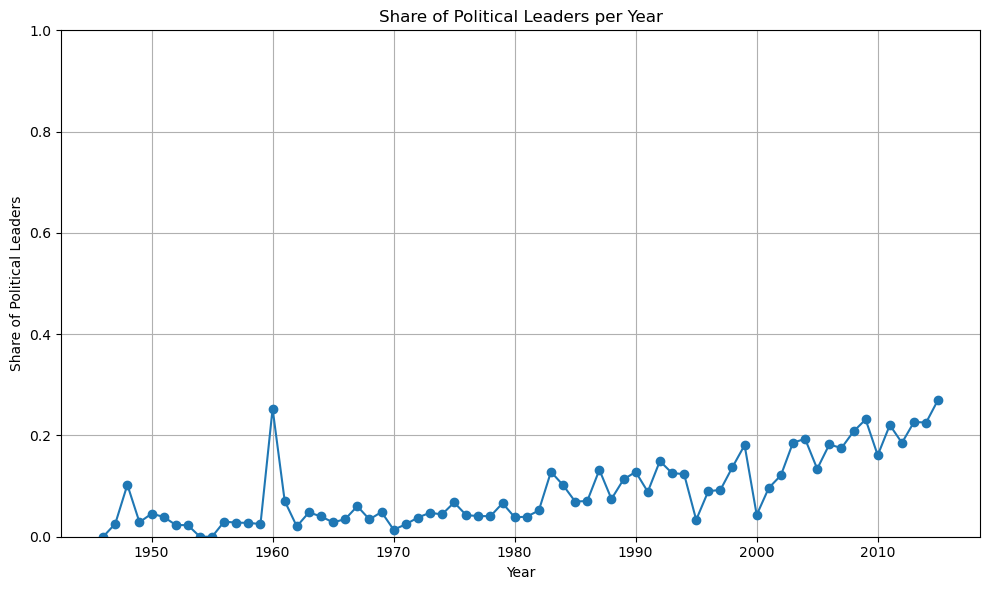

In [51]:
import matplotlib.pyplot as plt

# -----------------------
# Compute share of political leaders per year
# -----------------------
share_per_year = df_merged.groupby('year')['political_leader'].mean()

# -----------------------
# Plot
# -----------------------
plt.figure(figsize=(10, 6))
plt.plot(share_per_year.index, share_per_year.values, marker='o', linestyle='-')
plt.title("Share of Political Leaders per Year")
plt.xlabel("Year")
plt.ylabel("Share of Political Leaders")
plt.ylim(0, 1)  # share between 0 and 1
plt.grid(True)
plt.tight_layout()
plt.show()


In [651]:
# Filter rows where position is Monarch and either leader_first_period or leader_second_period exists
monarch_rows = df_merged[
    (df_merged['position'] == 'Monarch') &
    (df_merged['leader_first_period'].notna() | df_merged['leader_second_period'].notna())
]

# Select relevant columns
monarch_table = monarch_rows[['speaker_norm', 'leader_first_period', 'leader_second_period', 'year', 'country_code']]

# Display the table in Jupyter
display(monarch_table)


,speaker_norm,leader_first_period,leader_second_period,year,country_code
114,Hussein,Hussein Ibn Talal El-Hashim,None,1979,JOR
374,Hassan,Hussein Ibn Talal El-Hashim,None,1981,JOR
704,Sheikh Tamim Bin Hamad Al-Thani,Tamim ibn Hamad Al Thani,None,2015,QAT
1935,Mswati Iii,Cotti,None,1991,SWZ
2380,Abdullah Ii Ibn Al Hussein,Abdullah Ibn Hussein El-Hashimi,None,2015,JOR
2927,H M Hussein,Hussein Ibn Talal El-Hashim,None,1960,JOR
3939,Alfaisal,Khalid,None,1981,SAU
4172,Al-Faisal,Fahd,None,1986,SAU
10366,Hussein,Hussein Ibn Talal El-Hashim,None,1985,JOR


In [652]:
# Sheikh Tamim bin Hamad Al-Thani in 2015 → Political Leader
df_merged.loc[
    (df_merged['speaker_norm'] == 'Sheikh Tamim Bin Hamad Al-Thani') &
    (df_merged['year'] == 2015),
    'position'
] = 'Political Leader'

# JOR (Jordan) specific years → rename speaker and set Political Leader
jor_years = [1960, 1979, 1981, 1985]
df_merged.loc[
    (df_merged['country_code'] == 'JOR') &
    (df_merged['year'].isin(jor_years)),
    ['speaker_norm', 'position']
] = ['Hussein Ibn Talal El-Hashim', 'Political Leader']

# JOR 2015 → Political Leader
df_merged.loc[
    (df_merged['country_code'] == 'JOR') &
    (df_merged['year'] == 2015),
    'position'
] = 'Political Leader'

# All other rows in monarch_table → set position to Others
other_monarchs_mask = (
    (df_merged['position'] == 'Monarch') &
    ~(
        ((df_merged['speaker_norm'] == 'Sheikh Tamim Bin Hamad Al-Thani') & (df_merged['year'] == 2015)) |
        ((df_merged['country_code'] == 'JOR') & (df_merged['year'].isin(jor_years + [2015])))
    )
)
df_merged.loc[other_monarchs_mask, 'position'] = 'Others'

In [653]:
pd.set_option("display.max_rows", None)
position_counts = df_merged['position'].value_counts(dropna=False)
print(position_counts)

NaN                                      4455
Political Leader                         3653
(Deputy) Minister for Foreign Affairs    2387
Diplomatic Representative                 340
Others                                    117
Name: position, dtype: int64


### New Variable: Country (Year)

This variable is later needed to create clean description plots and tables

In [655]:
df_merged = df_merged.copy()
df_merged['speech_label'] = df_merged['country_name'] + " (" + df_merged['year'].astype(str) + ")"

### Save dataframe with all new variables as un_corpus_merged

In [657]:
os.chdir(wd)

merged_pickle_path = r".\data\un_corpus_merged.pkl"
df_merged.to_pickle(merged_pickle_path)
 
merged_output_path = r".\data\un_corpus_merged.csv"
df_merged.to_csv(merged_output_path, index=False, sep=';', encoding='utf-8')

___

## Cleaning & Pre-processing

#### Cleaning

In [661]:
# == Clean corpus by removing empty spaces, line breaks, hyphenation, stray characters, and escape quote ==

def cleaning(content):
    if pd.isna(content):
        return ""
    
    content = content.replace('\n', ' ').replace('\r', ' ')
    content = ' '.join(content.split())

    # Ensure spacing after punctuation
    content = re.sub(r'(?<=[.,])(?=[^\s])', r' ', content)

    # Remove hyphenation at line breaks (e.g. "inter- national" → "international")
    content = re.sub(r'-\s', '', content)

    # Replace hyphen between letters with a space to prevent merging words (e.g. "russian-and" → "russian and")
    content = re.sub(r'(?<=\w)-(?=\w)', ' ', content)

    content = content.replace("\\", "")

    return content

df_merged['speech'] = df_merged['speech'].astype(str)  # Ensure column is string type
df_clean = df_merged.copy()
df_clean['speech'] = df_clean['speech'].apply(cleaning)

# Drop rows with empty speeches after cleaning
df_clean = df_clean[df_clean['speech'].str.strip().astype(bool)].reset_index(drop=True)


In [662]:
# == Split cleaned data into chunks and save as separate files ==

clean_data = df_clean[['filename', 'speech']].values.tolist()

data_id1 = clean_data[:int(len(clean_data)/4)]
data_id2 = clean_data[int(len(clean_data)/4): int(2*len(clean_data)/4)]
data_id3 = clean_data[int(2*len(clean_data)/4): int(3*len(clean_data)/4)]
data_id4 = clean_data[int(3*len(clean_data)/4):]

os.chdir(data_temp)

joblib.dump(data_id1, 'clean_speeches_indexed1.pkl')
joblib.dump(data_id2, 'clean_speeches_indexed2.pkl')
joblib.dump(data_id3, 'clean_speeches_indexed3.pkl')
joblib.dump(data_id4, 'clean_speeches_indexed4.pkl')

# Store list of cleaned data chunk paths to feed into preprocessing function later
clean_files = [
    os.path.join(data_temp, 'clean_speeches_indexed1.pkl'),
    os.path.join(data_temp, 'clean_speeches_indexed2.pkl'),
    os.path.join(data_temp, 'clean_speeches_indexed3.pkl'),
    os.path.join(data_temp, 'clean_speeches_indexed4.pkl')
]

print(f"Saved clean speeches chunks in '{data_temp}'")

Saved clean speeches chunks in 'C:\Users\sarah\OneDrive\Dokumente\Masterarbeit\data\temp'


### Text Pre-Processing

#### Extend stopwords list

In [665]:
# Full path to stopwords pickle
stopwords_path = os.path.join(data_c, "stopwords.pkl")

# Load & sort stopwords
stopwords = joblib.load(stopwords_path)
stopwords = sorted(stopwords)

print(f"Loaded {len(stopwords)} stopwords (sorted alphabetically)")
print(stopwords[:300])

Loaded 18997 stopwords (sorted alphabetically)
['88', 'a', 'a.', 'aandahl', 'aaron', 'aaronsburg', 'aarp', 'abac', 'abbevill', 'abbitt', 'abbot', 'abbotsford', 'abbott', 'abbottstown', 'abbyvill', 'abdnor', 'abe', 'abel', 'abercrombi', 'aberdeen', 'abern', 'abernathi', 'abernethi', 'abi', 'abiel', 'abijah', 'abilen', 'abingdon', 'abington', 'abiquiu', 'abmp', 'abner', 'abourezk', 'about', 'abov', 'abraham', 'abram', 'absalom', 'absaraka', 'absaroke', 'absecon', 'abzug', 'acadia', 'acampo', 'accid', 'accokeek', 'accomac', 'accomack', 'accord', 'accovill', 'ace', 'acevedo-vilã¡', 'acheson', 'achill', 'acker', 'ackerman', 'ackermanvill', 'acklen', 'ackley', 'ackworth', 'acm', 'acosta', 'acra', 'acton', 'acushnet', 'acworth', 'ada', 'adah', 'adair', 'adairsvill', 'adairvill', 'adak', 'adam', 'adamsburg', 'adamson', 'adamstown', 'adamsvill', 'addabbo', 'addam', 'addi', 'addievill', 'addington', 'addison', 'addonizio', 'addyston', 'adel', 'adelanto', 'adelbert', 'adelphi', 'adelphia', 'adena

In [666]:
# Get SpaCy stopwords
#SPACY_STOPWORDS = list(nlp.Defaults.stop_words)
# Save stopwords
#joblib.dump(SPACY_STOPWORDS, stopwords_path)

#print(f"Saved {len(SPACY_STOPWORDS)} stopwords to {stopwords_path}")

In [667]:
# == Functions to remove punctioation, tokenize, lowercase, pure digit tokens, words shorter than 2 letters, POS-Tagging, stemm, stopword removal ==

def pro1(lista):
    return [[row[0], row[1].translate(translator)] for row in lista]

def pro2(lista):
    return [[row[0], gensim.utils.simple_preprocess(row[1])] for row in lista]

def pro3(lista):
        a = [[row[0], [w for w in row[1] if not w.isdigit()]] for row in lista]
        return a
    
def pro4(lista):
    return [[row[0], [w for w in row[1] if len(w) > 2]] for row in lista]


def tags(lista):
    t = [[row[0], tagger.tag(row[1])] for row in lista]  # tag each tokenlist
    t = [[row[0], [i[0] for i in row[1] if i[1].startswith(('N', 'V', 'J'))]] for row in t]
    return t
    
def pro5(lista):
    return [
        [row[0], [stemmer.stem(token) for token in row[1]]]
        for row in lista
    ]
    
def pro6(lista):
    return [[row[0], [w for w in row[1] if w not in stopwords]] for row in lista]
      
########################## Question for Max: They removed procedural words in the paper

def dropnull(lista):
    return [row for row in lista if len(' '.join(row[1])) > 0]

In [668]:
# == Create full pre-processing function and call it

def preprocessing(data_name):
    t0 = time.time()
    print(f"Starting preprocessing for {data_name}...")

    data = joblib.load(data_name)
    data = pro1(data)
    data = pro2(data)
    data = pro3(data)
    data = pro4(data)

    print(f"[{data_name}] Before tagging: {time.time() - t0:.2f}s")
    data = tags(data)
    print(f"[{data_name}] After tagging: {time.time() - t0:.2f}s")

    data = pro5(data)
    data = pro6(data)
    
    data = dropnull(data)

    filename_preprocessed = data_name.replace('clean_speeches_', 'preprocessed_speeches_').replace('.pkl', '.pkl')
    out_preprocessed = os.path.join(data_preprocessed, os.path.basename(filename_preprocessed))
    joblib.dump(data, out_preprocessed
               )
    print(f"[{data_name}] Saved stemmed version: {out_preprocessed}")

    print(f"[{data_name}] Done. Total time: {time.time() - t0:.2f}s\n")

def main():
    for fname in clean_files:
        preprocessing(fname)

if __name__ == "__main__":
    main()

Starting preprocessing for C:\Users\sarah\OneDrive\Dokumente\Masterarbeit\data\temp\clean_speeches_indexed1.pkl...
[C:\Users\sarah\OneDrive\Dokumente\Masterarbeit\data\temp\clean_speeches_indexed1.pkl] Before tagging: 14.91s
[C:\Users\sarah\OneDrive\Dokumente\Masterarbeit\data\temp\clean_speeches_indexed1.pkl] After tagging: 255.33s
[C:\Users\sarah\OneDrive\Dokumente\Masterarbeit\data\temp\clean_speeches_indexed1.pkl] Saved stemmed version: C:\Users\sarah\OneDrive\Dokumente\Masterarbeit\data\preprocessed\preprocessed_speeches_indexed1.pkl
[C:\Users\sarah\OneDrive\Dokumente\Masterarbeit\data\temp\clean_speeches_indexed1.pkl] Done. Total time: 1247.40s

Starting preprocessing for C:\Users\sarah\OneDrive\Dokumente\Masterarbeit\data\temp\clean_speeches_indexed2.pkl...
[C:\Users\sarah\OneDrive\Dokumente\Masterarbeit\data\temp\clean_speeches_indexed2.pkl] Before tagging: 13.64s
[C:\Users\sarah\OneDrive\Dokumente\Masterarbeit\data\temp\clean_speeches_indexed2.pkl] After tagging: 219.60s
[C:\U

In [669]:
# Store the pre-processed data
preprocessed_files = [
    os.path.join(data_preprocessed, 'preprocessed_speeches_indexed1.pkl'),
    os.path.join(data_preprocessed, 'preprocessed_speeches_indexed2.pkl'),
    os.path.join(data_preprocessed, 'preprocessed_speeches_indexed3.pkl'),
    os.path.join(data_preprocessed, 'preprocessed_speeches_indexed4.pkl')
]

In [670]:
# Load all preprocessed pickle files
preprocessed_data = []
for f in preprocessed_files:
    preprocessed_data.extend(joblib.load(f))

# Turn into DataFrame
df_preprocessed = pd.DataFrame(preprocessed_data, columns=["filename", "speech_preprocessed"])

# Merge into df_merged
df_merged = df_merged.merge(df_preprocessed, on="filename", how="left")

print(df_merged.head())


          filename                                             speech  \
0  AUT_11_1956.txt  Permit me first of all to express to Prince Wa...   
1  IDN_65_2010.txt   First I congratulate \nyou, Sir, on your assu...   
2  MNE_73_2018.txt  It is my pleasure to address the General Assem...   
3  BEN_19_1964.txt  74.\tIt is a particular pleasure for me, Mr. P...   
4  TTO_57_2002.txt  ﻿Please allow\nme to preface my indication by ...   

  country_code  year         country_name  speech_length_words  \
0          AUT  1956              Austria                 1850   
1          IDN  2010            Indonesia                 1361   
2          MNE  2018           Montenegro                 2089   
3          BEN  1964                Benin                 3686   
4          TTO  2002  Trinidad and Tobago                 2484   

   english_official_language  security_council_permanent  \
0                          0                           0   
1                          0                

In [671]:
# == New variable: Speech length of the preprocessed corpus ==

# Count tokens in preprocessed speech
df_merged["speech_length_preprocessed"] = df_merged["speech_preprocessed"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

# Quick check
print(df_merged[["filename", "speech_length_preprocessed"]].head())
all_tokens = [token for speech in df_merged["speech_preprocessed"].dropna() for token in speech]
unique_tokens = set(all_tokens)
print("Total unique tokens:", len(unique_tokens))

# Average length of preprocessed speeches
average_length = df_merged["speech_length_preprocessed"].mean()

print(f"Average number of tokens per speech: {average_length:.2f}")

          filename  speech_length_preprocessed
0  AUT_11_1956.txt                         650
1  IDN_65_2010.txt                         512
2  MNE_73_2018.txt                         815
3  BEN_19_1964.txt                        1247
4  TTO_57_2002.txt                         956
Total unique tokens: 36724
Average number of tokens per speech: 1078.01


In [672]:
print(df_merged.head())

          filename                                             speech  \
0  AUT_11_1956.txt  Permit me first of all to express to Prince Wa...   
1  IDN_65_2010.txt   First I congratulate \nyou, Sir, on your assu...   
2  MNE_73_2018.txt  It is my pleasure to address the General Assem...   
3  BEN_19_1964.txt  74.\tIt is a particular pleasure for me, Mr. P...   
4  TTO_57_2002.txt  ﻿Please allow\nme to preface my indication by ...   

  country_code  year         country_name  speech_length_words  \
0          AUT  1956              Austria                 1850   
1          IDN  2010            Indonesia                 1361   
2          MNE  2018           Montenegro                 2089   
3          BEN  1964                Benin                 3686   
4          TTO  2002  Trinidad and Tobago                 2484   

   english_official_language  security_council_permanent  \
0                          0                           0   
1                          0                

In [673]:
print(os.getcwd())

C:\Users\sarah\OneDrive\Dokumente\Masterarbeit\data\temp


---

## Word-Frequencies

### Count frequencies of all tokens and display the most common words

In [677]:
#== Count token frequencies ==

def count_frequencies(filenames):
    total_freq = Counter()
    for fname in tqdm(filenames):
        data = joblib.load(fname)
        tokens = chain.from_iterable(row[1] for row in data if isinstance(row[1], list))
        total_freq.update(tokens)
    return total_freq

#def remove_rare_words(filenames, freqs, min_count=10):
   # for fname in filenames:
       # data = joblib.load(fname)
       # filtered_data = []
        #for doc_id, tokens in data:
          #  filtered_tokens = [w for w in tokens if freqs.get(w, 0) >= min_count]
          #  filtered_data.append([doc_id, filtered_tokens])
       # joblib.dump(filtered_data, fname)  # overwrite or save as new file
       # print(f"Processed {fname}: removed words with freq < {min_count}")

# === Count for preprocessed (stemmed) speeches ===
word_counts = count_frequencies(preprocessed_files)

#remove_rare_words(preprocessed_files, word_counts, min_count=10)

print("\n[Stemmed] Top 50 most common words:")
for word, count in word_counts.most_common(50):
    print(f"{word}: {count}")

print("\n[Stemmed] Top 50 least common words:")
for word, count in word_counts.most_common()[-50:]:
    print(f"{word}: {count}")

# Save stemmed word counts
save_path = os.path.join(data_freq, 'word_counts.pkl')
joblib.dump(word_counts, save_path)

100%|██████████| 4/4 [00:18<00:00,  4.66s/it]



[Stemmed] Top 50 most common words:
nation: 234170
countri: 177834
intern: 161305
develop: 147090
world: 133091
peopl: 127487
secur: 86024
general: 77274
govern: 75551
econom: 73475
right: 67482
year: 66671
assembl: 58446
human: 57178
problem: 56809
support: 55692
continu: 53696
communiti: 49388
region: 48963
polit: 48469
time: 47497
need: 41509
import: 40881
achiev: 39487
make: 37987
conflict: 37632
presid: 37232
situat: 36254
principl: 36246
global: 36179
resolut: 35258
take: 35105
africa: 34787
great: 34066
relat: 33847
order: 33512
oper: 33395
concern: 33294
action: 32668
nuclear: 32246
solut: 32199
establish: 31713
made: 31378
confer: 31362
polici: 30730
commit: 30720
social: 30684
respect: 30371
effect: 30316
part: 29974

[Stemmed] Top 50 least common words:
therefar: 1
latterb: 1
exerciseof: 1
typewritten: 1
countriesstil: 1
unrespect: 1
moneylend: 1
btr: 1
omai: 1
slurri: 1
pland: 1
acceed: 1
fouad: 1
siniora: 1
inshaallah: 1
cpec: 1
sifc: 1
azm: 1
istehkam: 1
neutralis: 1
eti

['C:\\Users\\sarah\\OneDrive\\Dokumente\\Masterarbeit\\data\\freq\\word_counts.pkl']

In [678]:
num_unique_words = len(word_counts)
print(f"Number of unique words: {num_unique_words}")

Number of unique words: 36724


In [679]:
os.chdir(data_c)
print(os.getcwd())

C:\Users\sarah\OneDrive\Dokumente\Masterarbeit\data


### Count the frequency of the dictionary words

In [681]:
# == Count dictionary words

# Load dictionaries            ##### How did they come up with this dictionary? Why did they exclude words?

affect_path = os.path.join(data_dict, 'dictionary_affect.pkl')
cognition_path = os.path.join(data_dict, 'dictionary_cognition.pkl')

affect = joblib.load(affect_path)
cognition = joblib.load(cognition_path)

print("Contents of affect dictionary:")
print(affect)
print("Number of words in affect dictionary:", len(affect))

print("\nContents of cognition dictionary:")
print(cognition)
print("Number of words in cognition dictionary:", len(cognition))

a = [[i, word_counts[i]] for i in affect if i in word_counts]
c = [[i, word_counts[i]] for i in cognition if i in word_counts]

a = sorted(a, key=lambda x: x[1], reverse=True)
c = sorted(c, key=lambda x: x[1], reverse=True)

a = [[i[0], f"({i[1]}),"] for i in a]
c = [[i[0], f"({i[1]}),"] for i in c]

a1 = ' '.join(str(r) for v in a for r in v)
c1 = ' '.join(str(r) for v in c for r in v)

affect_out_path = os.path.join(data_freq, "affect_words.txt")
cog_out_path = os.path.join(data_freq, "cog_words.txt")

os.makedirs(data_freq, exist_ok=True)  # ensure directory exists

with open(affect_out_path, "w") as output:
    output.write(a1)

with open(cog_out_path, "w") as output:
    output.write(c1)


# == Calculate weighted frequencies for all words

l = sum(word_counts.values())

a = 0.001 # Method to downweight with a smoothing parameter: For frequent words (large v/1), weight approaches 0; for rare words (small v/1) closer to 1
word_counts_weighted = {k: a / (a + (v / l)) for k, v in word_counts.items()}

joblib.dump(word_counts_weighted, os.path.join(data_freq, 'word_counts_weighted.pkl'))

################################################################################ ISSUE##################
# To print top 100 by weighted values, sort the dictionary by value descending:
top_100_weighted = sorted(word_counts_weighted.items(), key=lambda x: x[1], reverse=True)[:100]

print("Top 100 words by weighted frequency:")
for word, weight in top_100_weighted:
    print(f"{word}: {weight}")

Contents of affect dictionary:
['forbid', 'unattract', 'cruelti', 'crappi', 'apathi', 'scari', 'unimpress', 'sin', 'dumbest', 'eas', 'agit', 'sob', 'shocker', 'tragedi', 'fabul', 'strongest', 'giver', 'sigh', 'aw', 'witch', 'hurtl', 'fucktard', 'cruel', 'glamor', 'funni', 'smarter', 'brillianc', 'irrate', 'alright', 'honest', 'profit', 'fearless', 'grievous', 'relax', 'isolationist', 'hah', 'shyness', 'poorest', 'cruelest', 'troublemak', 'disagre', 'agon', 'terror', 'fight', 'pleas', 'poor', 'crazi', 'hostil', 'stupid', 'damnat', 'vain', 'jade', 'heartless', 'nag', 'gloomi', 'damn', 'dishearten', 'pleaser', 'credit', 'warmth', 'greatest', 'whine', 'shame', 'angriest', 'envious', 'grin', 'blameless', 'sweeter', 'laidback', 'stupidest', 'unprotect', 'whiner', 'unlov', 'shake', 'boredom', 'fairer', 'weaker', 'wellb', 'bold', 'sucki', 'unsuccess', 'mourner', 'liken', 'defens', 'invigor', 'tedious', 'paranoid', 'cynic', 'dignifi', 'paranoia', 'sweetest', 'contented', 'humili', 'crush', 'ter

---

## Final Cleaning

In [684]:
os.chdir(data_freq)

word_counts = joblib.load('word_counts.pkl')  # load stemmed counts
# For each speech only keep tokens that appear at least 10x

def select(lista):
    for i in range(len(lista)):
        x = lista[i][0]
        y = lista[i][1]
        y = [w for w in y if word_counts.get(w, 0) >= 10]
        lista[i] = [x, y]
    return lista

for data_path in preprocessed_files:
    data = joblib.load(data_path)
    data = select(data)
    cleaned_path = data_path.replace('.pkl', '_final.pkl')
    joblib.dump(data, cleaned_path)

In [685]:
os.chdir(data_preprocessed)

final_files = [
    os.path.join(data_preprocessed, 'preprocessed_speeches_indexed1_final.pkl'),
    os.path.join(data_preprocessed, 'preprocessed_speeches_indexed2_final.pkl'),
    os.path.join(data_preprocessed, 'preprocessed_speeches_indexed3_final.pkl'),
    os.path.join(data_preprocessed, 'preprocessed_speeches_indexed4_final.pkl')
]

final_data = []
for fname in final_files:
    final_data.extend(joblib.load(fname))

# Merge with df_merged
df_final = pd.DataFrame(final_data, columns=["filename", "speech_final"])
df_merged = df_merged.merge(df_final, on="filename", how="left")

# Create speech_length_final column
df_merged["speech_length_final"] = df_merged["speech_final"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

# Quick check
print(df_merged[["filename", "speech_length_final"]].head())

all_tokens_final = [token for speech in df_merged["speech_final"].dropna() for token in speech]
unique_tokens_final = set(all_tokens_final)
print("Total unique tokens across all final speeches:", len(unique_tokens_final))

print("Average tokens per final speech:", df_merged["speech_length_final"].mean())


          filename  speech_length_final
0  AUT_11_1956.txt                  647
1  IDN_65_2010.txt                  511
2  MNE_73_2018.txt                  813
3  BEN_19_1964.txt                 1243
4  TTO_57_2002.txt                  955
Total unique tokens across all final speeches: 11035
Average tokens per final speech: 1072.8866873630386
